# FRED-Merchant Wholesalers - Alcoholic Beverages Sales - Time Series Prediction

> <a href= "https://fred.stlouisfed.org/series/S4248SM144NCEN"> Data Source</a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv(filepath_or_buffer="./Data/Alcohol_Sales.csv", index_col="DATE", parse_dates=True);df.head()
df.rename({"S4248SM144NCEN": "sales"}, axis = 1, inplace=True)
df.head()

,sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


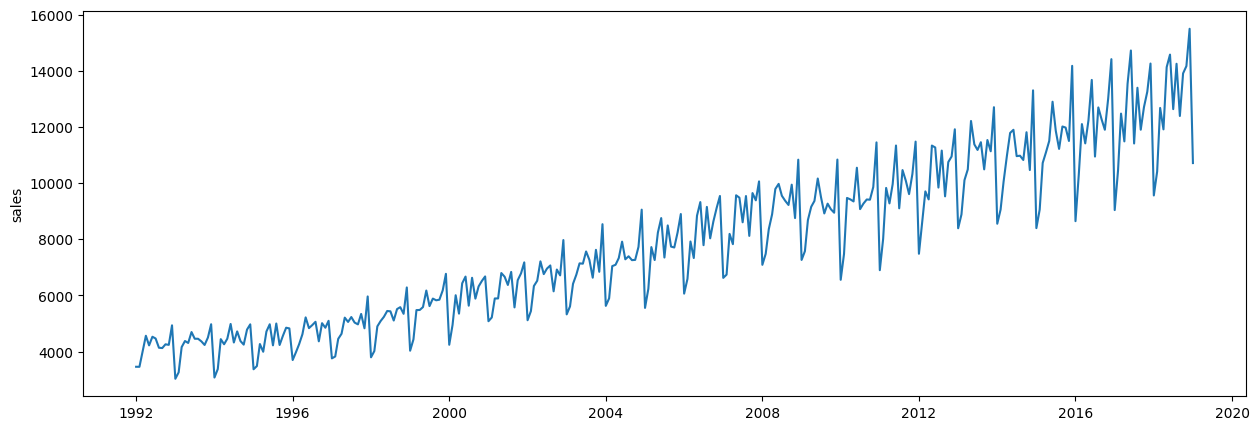

In [6]:
plt.figure(figsize = (15, 5))
plt.plot(df["sales"])
plt.ylabel("sales")
plt.show()

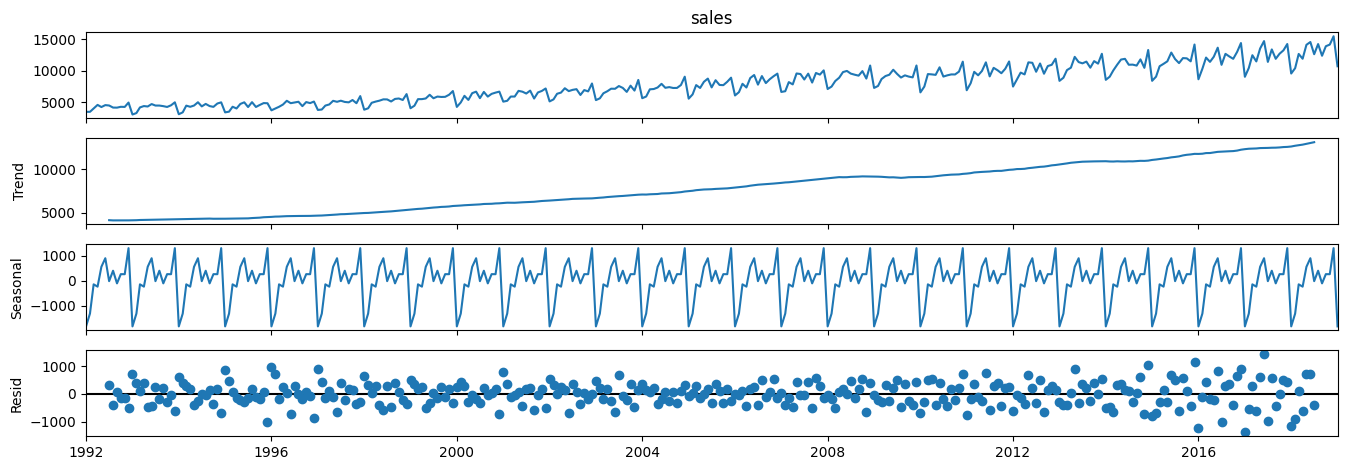

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df["sales"], model = "additive")
result.plot().set_figwidth(15)

<Axes: xlabel='DATE'>

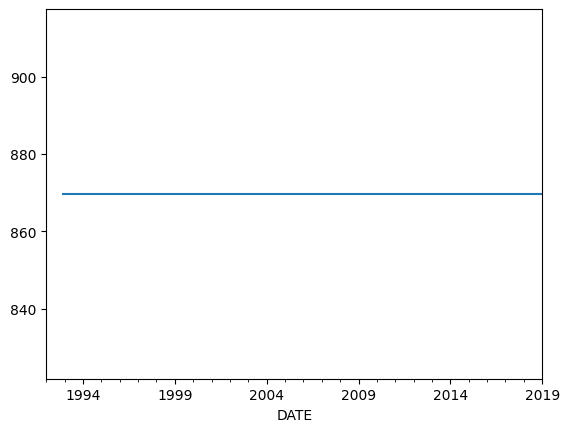

In [8]:
result.seasonal.rolling(window = 12).std().plot() # it can be seen that the amplitude of seasonal cycles does not change.

# splitting dataset

In [9]:
# we are going to predict next twelve month into the future and then when we are trained the model we are going to forecast beyond that


train = df.iloc[:len(df) - 12]
test = df.iloc[len(df) - 12:]

# normalize the data

In [10]:


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)



# creating batches for feeding neural network

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LSTM

In [14]:
model = Sequential()
model.add(Input(shape = (n_input, n_features)))
model.add(LSTM(175, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "mse",
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 175)            │       123,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,076 (484.67 KB)

 Trainable params: 124,076 (484.67 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(generator, epochs = 20)

Epoch 1/20


c:\Users\yy\Anaconda3\envs\ml_gpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0219
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0081
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 9/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024
Epoch 10/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 11/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032
Epoch 12/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 13/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 14/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017
Epoch 15/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019


<Axes: xlabel='epochs', ylabel='loss-mse'>

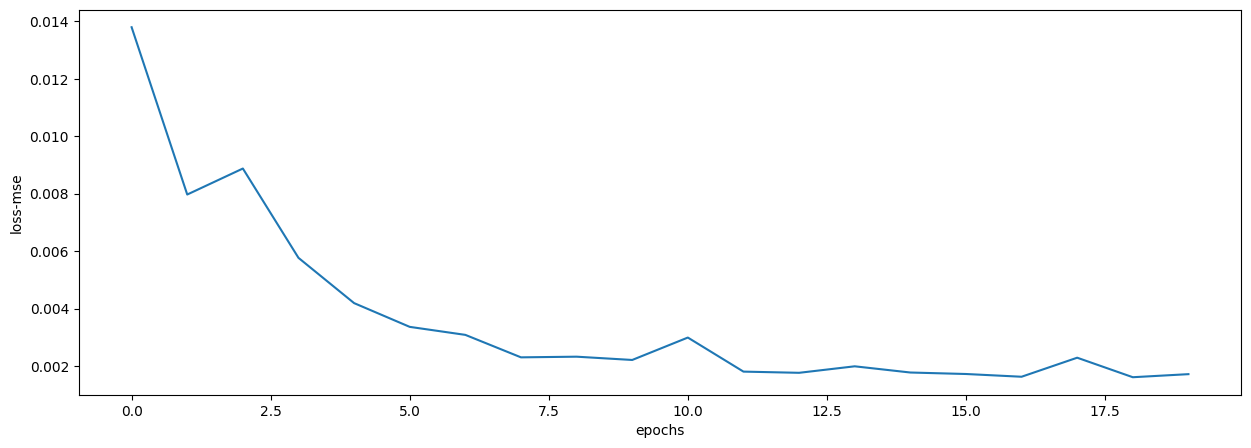

In [16]:
pd.Series(model.history.history["loss"]).plot(ylabel = "loss-mse", xlabel="epochs", figsize = (15, 5))

In [17]:
first_eval_batch = scaled_train[-12:] # last 12 month of train set
first_eval_batch = first_eval_batch.reshape(1, 12, 1)

In [18]:
model.predict(first_eval_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


array([[0.6991409]], dtype=float32)

In [19]:
test_prediction = []
first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape(1, 12, 1)
for i in range(len(test)):

    current_pred = model.predict(current_batch)[0].item()
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[[current_pred]]], axis = 1)

predictions = np.array(test_prediction).reshape(-1,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [20]:
unscaled_prediction = scaler.inverse_transform(predictions)
unscaled_test_data = scaler.inverse_transform(scaled_test)

# RMSE

In [21]:
from sklearn.metrics import root_mean_squared_error


root_mean_squared_error(unscaled_test_data, unscaled_prediction)

540.3619252463961

# r2 Score

In [22]:
from sklearn.metrics import r2_score

r2_score(unscaled_test_data, unscaled_prediction)

0.8719713349071138

In [23]:
predictions = pd.Series(data = unscaled_prediction.flatten(), index = test.index)

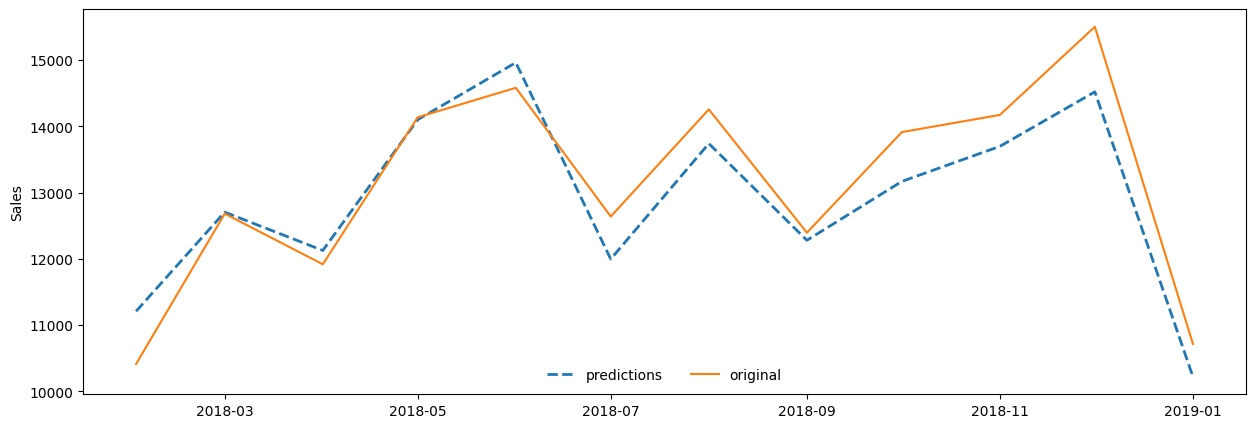

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(predictions, label = "predictions", linestyle = "--", lw = 2)
ax.plot(test, label = "original")
plt.ylabel("Sales")
plt.legend(loc = "lower center", ncols = 2, framealpha = 0)
plt.show()

# predictions beyond test dataset

In [25]:
test_prediction = []
first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape(1, 12, 1)

for i in range(len(test) + 24):

    current_pred = model.predict(current_batch)[0].item()
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[[current_pred]]], axis = 1)

predictions = np.array(test_prediction).reshape(-1,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [28]:
forecast_beyond_test_data = pd.Series(data = scaler.inverse_transform(predictions).flatten(), index = pd.date_range(start=test.index[0], periods=36, freq="MS"))

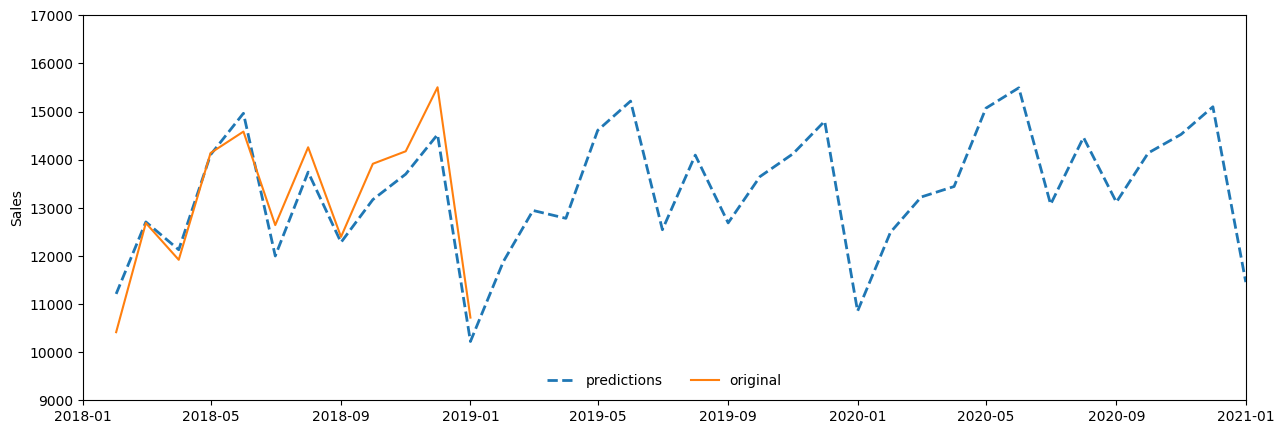

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
# ax.plot(train)
ax.plot(forecast_beyond_test_data, label = "predictions", linestyle = "--", lw = 2)
ax.plot(test, label = "original")
plt.ylabel("Sales")
plt.legend(loc = "lower center", ncols = 2, framealpha = 0)
plt.ylim((9000, 17000))
plt.xlim(pd.Timestamp("2018-01-01"), pd.Timestamp("2021-01-01"))
plt.show()

<a><img src='./Screenshot 2025-03-04 145805.png'/></a>

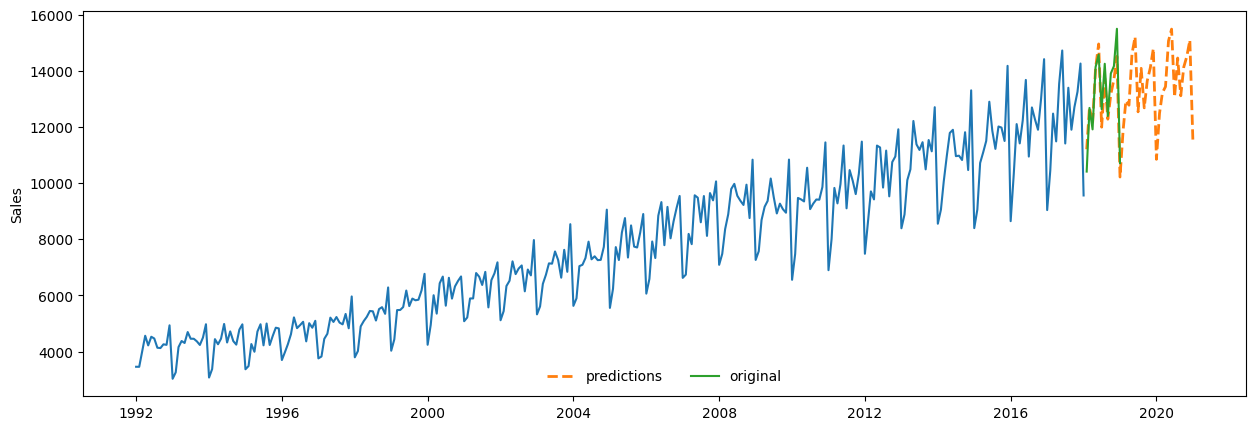

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(train)
ax.plot(forecast_beyond_test_data, label = "predictions", linestyle = "--", lw = 2)
ax.plot(test, label = "original")
plt.ylabel("Sales")
plt.legend(loc = "lower center", ncols = 2, framealpha = 0)
plt.show()